# Notebook batch-1831-land-cover-mapping

## Imports

In [91]:
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shutil
import os
import rasterio


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [154]:
import os

# Spécifiez le chemin vers votre fichier JSON téléchargé
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "data/gleaming-tube-438915-v7-9d3a41dc942d.json"

### Approche globale 

- Consolider l'ensemble des bases de données pour le projet & répartir les images dans des dossiers train & val
- Identifier, construire un modèle et l'entrainer le modèle en local puis avec TensorFlow DataSet à partir des buckets
- Finetuner le modèle
- Appliquer à google map (incl. API)
- Construire l'interface
- Investiguer les applications business/concrètes possibles

## Data preparation

Télécharger l'ensemble des données, les consolder et construire le train, val, test set

**Approche :**
- Télécharger les set de données (OpenG & XBD), consolider l'ensemble
- Identifier le nom des images pour les sets (train/val/test)
- Processer les images (ex: np.transpose)
- Calculer les différentes résolutions disponibles et les cas à appliquer (crop/diviser les images) pour faciliter l'entrainement
- Vérifier si certaines données (esp. labels) sont manquantes
- Construire les dossier train / val + test

### Uploader les images manquantes de XBD

In [2]:
########### IL VA FALLOIR UPLOADER LES ELEMENTS MANQUANTS ################

# Code qui regarde un csv, cherche le bon fichier dans la BDD XBD, le transforme en numpy array (code Chat utile) 
# et le met dans le bon dossier avec le bon nom via la table de correspondance

In [3]:
# ✅✅✅✅✅

# On pourrait directement passer à l'étape construire les dossiers train/val/test mais je préfère avoir un bon raw data consolidée

def xbd_paths(path):
    #On charge le fichier de correspondance pour le manipuler et construire les chemins sources & destination
    df = pd.read_csv(path, header = None, names = ["source", "destination"])
    df['source'] = df['source'].str.replace(".png",  ".tif")

    #on construit les chemins sources où chercher les images 
    sources = list(df["source"])
    sources = ["raw_data/XBD/images/" + source for source in sources]

    #on construit les chemins de destinations où iront les images
    destinations = list(df["destination"])
    destination_paths = []
    dossiers = []
    for destination in destinations:
        dossier = "_".join(destination.split("_")[:-1])
        dossiers.append(dossier) # Certains noms de ville sont composés, il faut tout prendre sauf ce qui vient après le dernier _
        destination_paths.append("raw_data/" + dossier + "/images/" + destination)
    return sources, destination_paths, dossiers

In [4]:
### ✅✅✅✅✅ On construit les variables de paths pour copier les fichiers
sources, destinations, dossiers = xbd_paths("raw_data/xbd_files.csv")

In [5]:
### ✅✅✅✅✅ On prend chaque fichier, on le convertit en numpy array et on le met dans les bons dossiers 

for source, destination in zip(sources, destinations):
    shutil.copy(source, destination)

### Finaliser le listing des chemins pour construire les dossiers train/val

In [6]:
#✅✅✅✅✅ Création d'un listes avec les noms des fichiers à prendre

#On construit une fonction qui va retourner le chemin vers 1) 
#les images du X 2) les images du y - en fonction du paramètre donnee qui est "train", "test", "val"
def read_txt(donnee):
    with open(f"raw_data/{donnee}.txt", 'r') as file:
        lines = file.readlines()
        X = []
        y = []
        for line in lines:
            region = line.split("_")[0]
            title = line.replace('\n', '')
            X.append("raw_data/"+ region + "/images/" + title)
            y.append("raw_data/"+ region + "/labels/" + title)
        return X, y

In [7]:
# ✅✅✅✅✅ On crée les listes pour les différents train et test
X_train_set, y_train_set = read_txt("train")
X_val_set, y_val_set = read_txt("val")
X_test_set, y_test_set = read_txt("test")

In [9]:
# ✅✅✅✅✅ On definit nos set de données finaux (quand X et y existent)
X_train_set_final = []
y_train_set_final = []
train_files = []

X_val_set_final = []
y_val_set_final = []
val_files = []

X_test_set_final = []
y_test_set_final = []
test_files = []


for X, y in zip(X_train_set, y_train_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_train_set_final.append(X)
        y_train_set_final.append(y)
        train_files.append(X.split("/")[-1])

for X , y  in zip(X_test_set, y_test_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_test_set_final.append(X)
        y_test_set_final.append(y)
        test_files.append(X.split("/")[-1])


for X, y  in zip(X_val_set, y_val_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_val_set_final.append(X)
        y_val_set_final.append(y)
        val_files.append(X.split("/")[-1])

### Créer et peupler les dossiers train/val/test

In [10]:
# ✅✅✅✅✅ On construit une fonction qui va aller chercher les images dont le chemin est 
#indiqué dans le set et les sauvegarder dans un dossier train ou val (en fonction du X et du y) 
i = 0
# on copie les fichiers pour le train
for X_train, y_train in zip(X_train_set_final, y_train_set_final):
    dst_X_train = "clean_data/train/images/"
    os.makedirs(os.path.dirname(dst_X_train), exist_ok=True)
    shutil.copy(X_train, dst_X_train + X_train.split("/")[-1])
    
    dst_y_train = "clean_data/train/labels/"
    os.makedirs(os.path.dirname(dst_y_train), exist_ok=True)
    shutil.copy(y_train, dst_y_train + y_train.split("/")[-1])


#on copie les fichiers sur le val 

for  X_val, y_val in zip( X_val_set_final, y_val_set_final):

    dst_X_val = "clean_data/val/images/"
    os.makedirs(os.path.dirname(dst_X_val), exist_ok=True)
    shutil.copy(X_val, dst_X_val + X_val.split("/")[-1])

    dst_y_val = "clean_data/val/labels/"
    os.makedirs(os.path.dirname(dst_y_val), exist_ok=True)
    shutil.copy(y_val, dst_y_val + y_val.split("/")[-1])

In [42]:
### ✅✅✅✅✅ Fonction pour slicer une image
def slicing(image_array, nb_tuiles):
    tuiles_arrays = []
    for tuiles_verticales in range(nb_tuiles):
        for tuiles_horizontales in range(nb_tuiles):
            tuiles_arrays.append(image_array[tuiles_verticales * 256 : 256 * (tuiles_verticales + 1),\
                                 tuiles_horizontales * 256: 256 * (tuiles_horizontales + 1)])
    return tuiles_arrays

In [44]:
with rasterio.open("clean_data/train/images/zanzibar_53.tif") as src:
    image_array = src.read()  # (nb_bands, height, width)
    image_array = np.transpose(image_array, (1, 2, 0))
tuiles_arrays = slicing(image_array, 4)

In [211]:
def save_tuile(tuiles_arrays, train_file, data_set, images_or_label ):
    path = "processed_data/" + data_set + "/" + images_or_label + "/"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    for tuile_id, tuile_array in enumerate(tuiles_arrays):
        if tuile_array.shape[-1] == 1 :
            tuile_array = np.squeeze(tuile_array)
        tuile_array = tuile_array.astype("uint8")
        image = Image.fromarray(tuile_array)
        image.save(path + "/"  + train_file.split(".")[0] + "_" + str(tuile_id + 1) + ".tif")
        

In [212]:
def crop_tuile(data_set):
    if data_set == "train":
        files = train_files
    elif data_set == "val":
        files = val_files
    path = "clean_data/" + data_set + "/"
    #On ouvre chaque image X puis chaque image y. Commençons par les X
    ## Ouverture des X - théoriquement les images seront de même taille
    for file in files:
        
        with rasterio.open(path + "images/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))
        
        #ensuite on regarde en combien de tuiles on peut le faire
        nb_tuiles = (image_array.shape[0] // 256) # Sur une longueur ou hauteur on peut fiter nb_tuiles + un reste de pixels qui sera perdu
        tuiles_totales = nb_tuiles **2 # ça nous aidera pour le nommage des tuiles (ex = aachen_1_2 - tuile 2 de la photo aachen_1
        #il faudra donc slicer en nb_tuiles à la verticale et à la horizontale

        #On va slicer le X
        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "images")
    
        with rasterio.open(path + "labels/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #on slide le y de la même manière que le X avec la même convention de nommage (donc le même nom 

        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "labels")
                

In [215]:
#On lance le crop sur toutes les données de train et de val 
crop_tuile("train")
crop_tuile("val")

## Construire le modèle U-NET

### Définir le modèle UNET et l'initialiser

In [140]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_304 (Conv2D)         (None, 256, 256, 64)         1792      ['input_17[0][0]']            
                                                                                                  
 conv2d_305 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_304[0][0]']          
                                                                                                  
 max_pooling2d_64 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_305[0][0]']          
 ng2D)                                                                                        

### [INUTILE POUR LE TRAIN AT SCALE GRACE AUX TENSORFLOW DATASETS] 
### Construire les X_train et X_val, y_train et y_val

In [63]:
X_train = []
y_train = []
path_images = "data/processed_data/train/images/"
for path in os.listdir(path_images)[0:2000]:
    with rasterio.open(path_images + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        X_train.append(image_array/255)

path_labels = "data/processed_data/train/labels/"
for path in os.listdir(path_labels)[0:2000]:
    with rasterio.open(path_labels + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        y_train.append(image_array)

In [64]:
X_train = np.array(X_train)
y_train = np.array(y_train)

## Tensorflow Data Set 

In [93]:
# Chemins des images
input_images_dir = "data/processed_data/train/images"
target_images_dir = "data/processed_data/train/labels"

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1
    
    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1
    
    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))
    
    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")
    
    return input_paths, target_paths

# Charger les chemins des images
input_image_paths, target_image_paths = get_image_paths(input_images_dir, target_images_dir)

# Mélanger les chemins des images de manière synchrone
input_image_paths, target_image_paths = shuffle(input_image_paths, target_image_paths, random_state=42)

# Limiter le nombre d'images
test_limit = 200
input_image_paths = input_image_paths[:test_limit]
target_image_paths = target_image_paths[:test_limit]

# Diviser en ensembles d'entraînement et de validation
train_input_paths, val_input_paths, train_target_paths, val_target_paths = train_test_split(
    input_image_paths, target_image_paths, test_size=0.2, random_state=42
)

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible
print(f"Nombre d'images d'entrée : {len(input_image_paths)}")
print(f"Nombre d'images cibles : {len(target_image_paths)}")

Nombre d'images d'entrée : 200
Nombre d'images cibles : 200


In [178]:
## Callbacks 
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


In [179]:
model.fit(train_dataset, epochs = 100, batch_size = 32, callbacks = [es, cp], validation_data =val_dataset)

Epoch 1/100
      5/Unknown - 12s 2s/step - loss: 1.5071 - accuracy: 0.4169

2024-12-11 15:35:36.874661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6007436103853888278
2024-12-11 15:35:36.874671: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5799135325865611983
2024-12-11 15:35:36.874696: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3855673302714324868


5/5 [==============================] - 13s 3s/step - loss: 1.5071 - accuracy: 0.4169 - val_loss: 1.6150 - val_accuracy: 0.4411
Epoch 2/100
5/5 [==============================] - 13s 3s/step - loss: 1.4956 - accuracy: 0.4223 - val_loss: 1.6108 - val_accuracy: 0.4659
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 1.5044 - accuracy: 0.4139 - val_loss: 1.5903 - val_accuracy: 0.4525
Epoch 4/100
5/5 [==============================] - 13s 3s/step - loss: 1.4814 - accuracy: 0.4118 - val_loss: 1.5865 - val_accuracy: 0.4373
Epoch 5/100
5/5 [==============================] - 14s 3s/step - loss: 1.4949 - accuracy: 0.4080 - val_loss: 1.5789 - val_accuracy: 0.4667
Epoch 6/100
5/5 [==============================] - 13s 3s/step - loss: 1.4856 - accuracy: 0.4174 - val_loss: 1.5746 - val_accuracy: 0.4465
Epoch 7/100
5/5 [==============================] - 13s 3s/step - loss: 1.4900 - accuracy: 0.4127 - val_loss: 1.6134 - val_accuracy: 0.3828
Epoch 8/100
5/5 [======================

VertexAI connecté au bucket et qui prend 16 par 16 
Sauvegarder le modèle toutes les X epochs 

1/1 [==============================] - 0s 216ms/step


2024-12-11 14:42:15.471953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(1, 256, 256, 3)

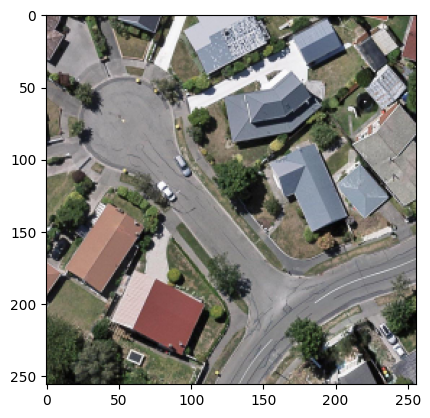

In [117]:
### Test 
path = "data/processed_data/train/images/christchurch_12_4.tif"
im = Image.open(path)
plt.imshow(im)
X_new = np.array(im)
X_new = np.expand_dims(X_new, axis = 0)
y_pred = model_3.predict(X_new/255)

In [135]:
classes= np.squeeze(tf.argmax(y_pred, axis=-1, output_type=tf.int32).numpy())

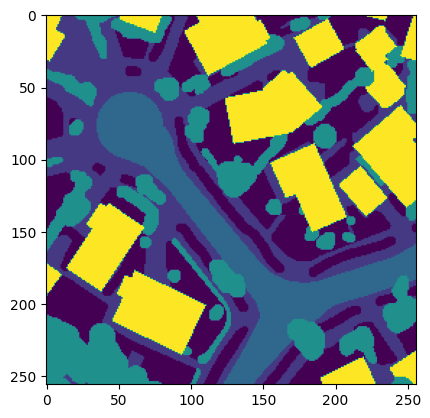

In [137]:
path = "data/processed_data/train/labels/christchurch_12_4.tif"
im_2 = Image.open(path)
plt.imshow(im_2)

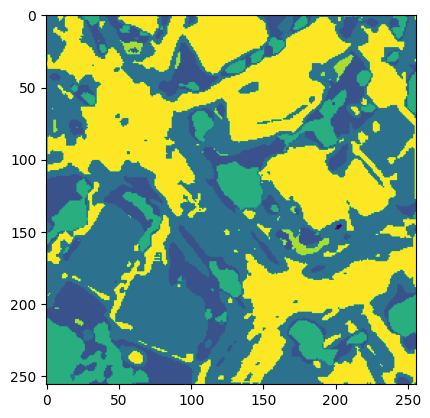

In [136]:
plt.imshow(classes), plt.imshow(classes)